In [15]:
from binance.client import Client

client = Client()

# ETH
# klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "6 months ago UTC")

klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "6 months ago UTC")


In [21]:
import pandas as pd
import pandas_ta as ta
import numpy as np

df = pd.DataFrame(klines, columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_vol", \
                                    "trades", "taker_base_vol", "taker_quote_vol", "ignore"])

df = df[["open_time","open", "high", "low", "close"]]

df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")

df["open"] = df.open.astype(float)
df["high"] = df.high.astype(float)
df["low"] = df.low.astype(float)
df["close"] = df.close.astype(float)

## take the rolling atr so the yaxis doesn't shake too much
df["atr"] = ta.atr(high=df.high, low=df.low, close=df.close)
df["atr"] = df.atr.rolling(window=30).mean()

df.set_index("open_time", inplace=True)
df

,open,high,low,close,atr
open_time,,,,,
2022-09-22 11:00:00,19148.97,19272.06,19030.39,19229.81,NaN
2022-09-22 12:00:00,19229.81,19317.66,19141.00,19203.61,NaN
2022-09-22 13:00:00,19203.61,19221.26,18889.34,18903.67,NaN
2022-09-22 14:00:00,18902.81,19073.50,18849.67,18880.22,NaN
2022-09-22 15:00:00,18881.50,19026.58,18794.06,18986.89,NaN
...,...,...,...,...,...
2023-03-22 06:00:00,28201.53,28218.58,28151.00,28205.16,286.947002
2023-03-22 07:00:00,28205.16,28238.83,28028.24,28103.69,282.901311
2023-03-22 08:00:00,28103.68,28213.23,28053.71,28086.99,279.204146


In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from IPython import display
from IPython.display import HTML
pd.set_option("mode.chained_assignment", None)

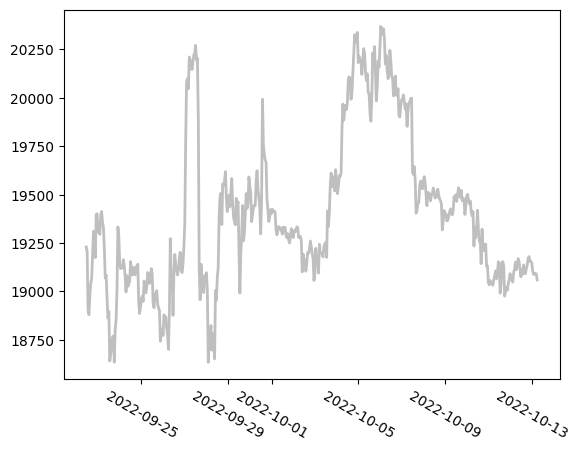

In [23]:
df2 = df.iloc[0:500]

fig, ax = plt.subplots()

plt.xticks(rotation=-30)

price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)

plt.show()

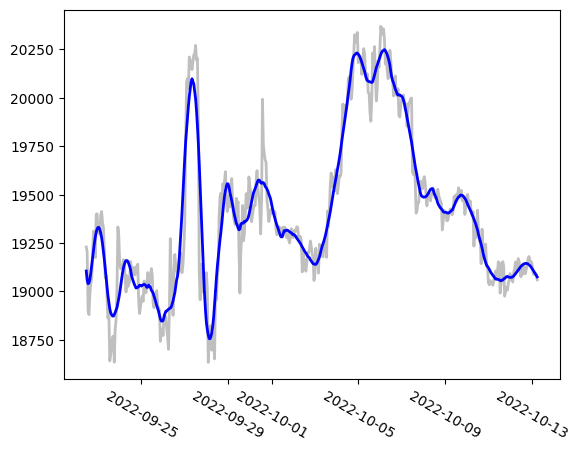

In [24]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

plt.show()

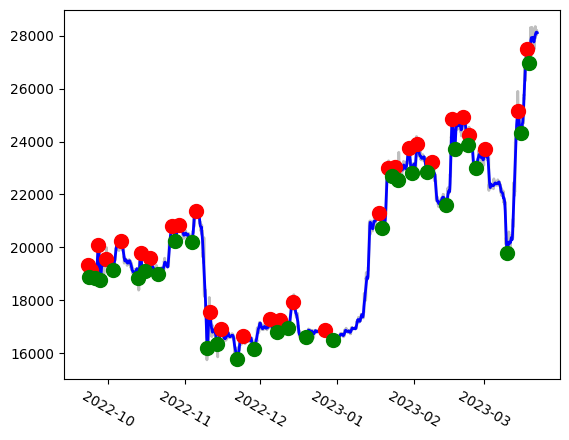

In [25]:
# df2 = df.iloc[0:500]
df2 = df

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

atr = df2.atr.iloc[-1]

peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

peaks, = ax.plot(df2.index[peaks_idx], df2.close_smooth.iloc[peaks_idx], \
                c="r", linestyle="None", markersize=10.0, marker="o", zorder=10)

thoughs, = ax.plot(df2.index[troughs_idx], df2.close_smooth.iloc[troughs_idx], \
                c="g", linestyle="None", markersize=10.0, marker="o", zorder=10)

plt.show()

In [26]:
peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

print(peaks_idx)
print(troughs_idx)


[  13   45  117  191  330  523  614  824  895 1053 1189 1302 1511 1771
 1866 1994 2295 2824 2907 2971 3109 3189 3327 3527 3633 3690 3844 4159
 4247]
[  30   84  137  253  503  566  691  859 1016 1167 1258 1455 1611 1837
 1941 2121 2377 2850 2943 2998 3134 3279 3466 3548 3674 3749 4054 4186
 4264]


In [27]:
# Create a new column in the DataFrame called "position"
df2['long_short_position'] = 0

# Set position values based on long and short signals
# df2['long_short_position'] = np.zeros(len(df))
df2['long_short_position'].iloc[peaks_idx] = 1
df2['long_short_position'].iloc[troughs_idx] = -1

# Adjust the position column to hold the most recent position until there is a signal to go in the other direction
prev_pos = 0
for i in range(len(df)):
    if df2['long_short_position'][i] != 0:
        prev_pos = df2['long_short_position'][i]
    else:
        df2['long_short_position'][i] = prev_pos

# df2 = df2.drop(['position', 'LongShortPosition'], axis = 1)

df2[25:55]

,open,high,low,close,atr,close_smooth,long_short_position
open_time,,,,,,,
2022-09-23 12:00:00,18862.72,18956.98,18825.00,18896.74,NaN,18945.534656,1
2022-09-23 13:00:00,18896.74,19077.02,18624.05,18641.04,NaN,18911.426823,1
2022-09-23 14:00:00,18640.69,18749.02,18531.42,18674.45,NaN,18890.732099,1
2022-09-23 15:00:00,18674.41,18855.00,18586.00,18711.86,NaN,18880.426950,1
2022-09-23 16:00:00,18712.08,18788.42,18572.55,18765.54,NaN,18873.498562,1
2022-09-23 17:00:00,18766.72,18852.28,18633.25,18770.00,NaN,18872.808986,-1
2022-09-23 18:00:00,18770.00,18834.42,18620.28,18635.02,NaN,18881.244939,-1
2022-09-23 19:00:00,18636.12,18829.71,18620.31,18807.57,NaN,18891.502073,-1
2022-09-23 20:00:00,18807.57,18956.85,18807.57,18852.17,NaN,18903.857833,-1


In [30]:
import backtesting

df2 = df2.rename(columns={"open": "Open", "close": "Close", "low": "Low", "high": "High"})

class MyStrategy(backtesting.Strategy):
    
    stop_loss_percent = 15
    last_purchase_price = 0
    long_hold = 0
    short_hold = 0
    i = 0
    
    def init(self):
        super().init()
        
    def next(self):
        super().init()

        self.i += 1

        long_entry_signals = 0
        long_exit_signals = 0
        short_entry_signals = 0
        short_exit_signals = 0


        # print(self.data.long_short_position)
        
        
    
        # If long_short_position is 1, go long
        if self.data.long_short_position == -1:
            long_entry_signals += 1
            short_exit_signals += 1
        # If long_short_position is -1, go short
        if self.data.long_short_position == 1:
            long_exit_signals += 1
            short_entry_signals += 1
      
        #  Stop loss
        price = self.data.df['close_smooth'][-1]
        if price <= self.last_purchase_price * (1 - self.stop_loss_percent/100):
            long_exit_signals += 1

        if price >= self.last_purchase_price * (1 + self.stop_loss_percent/100):
            short_exit_signals += 1

        #  LONG
        #--------------------------------------------------
        if self.long_hold == 0 and long_entry_signals >= 1:
            #  Buy
            self.long_hold = 1
            self.position.close()
            self.buy()
            self.last_purchase_price = price

        elif self.long_hold == 1 and long_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.long_hold = 0
            self.position.close()
            self.last_purchase_price = 0

        #  SHORT
        #--------------------------------------------------
        if self.short_hold == 0 and short_entry_signals >= 1:
            #  Sell
            self.short_hold = 1
            self.position.close()
            self.sell()
            self.last_purchase_price = price

        elif self.short_hold == 1 and short_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.short_hold = 0
            self.position.close()
            self.last_purchase_price = 0
            
# Backtest the strategy
bt = backtesting.Backtest(df2, MyStrategy, cash=30000, commission=0.002)
results = bt.run()

# Print the results
print(results)

Start                     2022-09-22 11:00:00
End                       2023-03-22 10:00:00
Duration                    180 days 23:00:00
Exposure Time [%]                   99.677716
Equity Final [$]                 429036.17868
Equity Peak [$]                  432695.12868
Return [%]                        1330.120596
Buy & Hold Return [%]               46.200144
Return (Ann.) [%]                20653.603901
Volatility (Ann.) [%]             8408.174891
Sharpe Ratio                         2.456372
Sortino Ratio                     4063.315045
Calmar Ratio                      5389.101668
Max. Drawdown [%]                   -3.832476
Avg. Drawdown [%]                   -0.759559
Max. Drawdown Duration        6 days 08:00:00
Avg. Drawdown Duration        0 days 13:00:00
# Trades                                   58
Win Rate [%]                            100.0
Best Trade [%]                      28.618836
Worst Trade [%]                      0.686072
Avg. Trade [%]                    

In [31]:
bt.plot()

Row(id='1350', ...)